# <center> Course Project Part 1 & 2 </center>

# &#10004; **Part I**

### &#10148; Import

- Import all packages required for Part 1 & 2

In [1]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
from xgboost import XGBClassifier
#--------------------------------------------------#
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#--------------------------------------------------#
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#--------------------------------------------------#
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#--------------------------------------------------#
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
#--------------------------------------------------#
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#--------------------------------------------------#

# Vader
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#--------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")
#--------------------------------------------------#
from typing import Optional, Union, Tuple, Type, Sequence, List, Set, Dict, Any, TextIO, IO




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cesiu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### &#10148; Deal with different environments. 
- Make sure the notebook runs properly in different environments.

In [2]:
#====================================================================================================#
# Install google-related packages. 

# !pip install google-colab
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-vision
# !pip install --upgrade google-api-python-client

#====================================================================================================#
# Identify if the env is google colab.
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_1      = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_file   = '/content/gdrive/MyDrive/sentiment_analysis.csv' 
    data_folder = Path("./")




### &#10148; Load and clean the original dataset.
In this block, 
- Data is loaded into the notebook as a dataframe. 
- A function is defined to print out more details of the dataset. 
- Print out the dataframe. 

In [3]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file   = "sentiment_analysis.csv"

#====================================================================================================#
# For clearly print a dataframe. 
def beautiful_print(df): # Print the DataFrame obtained (May NOT work properly in jupyter notebook).
    # Print the dataset in a well-organized format.
    with pd.option_context('display.max_rows'       , 20   , 
                           'display.min_rows'       , 20   , 
                           'display.max_columns'    , 15   , 
                           "display.max_colwidth"   , 120 ,
                           "display.width"          , None ,
                           "expand_frame_repr"      , True ,
                           "max_seq_items"          , None , ):  # more options can be specified
        # Once the display.max_rows is exceeded, 
        # the display.min_rows options determines 
        # how many rows are shown in the truncated repr.
        print(df)
    return 

#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw = pd.read_csv(filepath_or_buffer   =   data_folder/data_file             ,
                     header               =   0                                 , 
                     #index_col           =   0                                 ,
                     encoding             =   "ISO-8859-1"                      ,
                     sep                  =   ','                               ,  
                     low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: ")
print("df_raw.shape: ", df_raw.shape) # 3 columns. 
#beautiful_print(df_raw)
print(df_raw.head(5))





Raw dataset printed below: 
df_raw.shape:  (550391, 3)
             ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1



### &#10148; Define a list of functions for cleaning and preprocessing the text data
The list of functions will be implemented to, (in the following order)
- Preprocess (commonly done to text data) 
    - Remove whitespace
    - Unescape html and replace html character codes with ascii equivalent
    - Remove URLs.
    - Remove duplicate spaces.
    - Remove html tags, user tags
- Identify language and screen English comments
- Clean text
    - Remove HTML tags
    - Remove user tags
    - Remove URLs
    - Remove non-alphanumeric characters
    - Remove "#" in Hashtags
    - Remove Retweet
    - Remove unicode
    - Remove non-ASCII chars (for test only)


In [4]:
# A list of functions for clean the text data

#====================================================================================================#
# Extra Options for preprocessing text data.
def clean_text_preproc(text):
    # List of extra functions for dealing with raw text. 
    #--------------------------------------------------#
    # (1) Replace newlines with spaces.
    def remove_whitespace(s):
        return re.sub(r"\n{1,}|\\n{1,}|\r{1,}|\\r{1,}|\t{1,}|\\t{1,}", " ", s)
    # (2) Unescape html and replace html character codes with ascii equivalent.
    def unescape_html(s):
        return html.unescape(s)
    # (3) remove URLs.
    def remove_urls(s):
        return re.sub(r"\b(http:\/\/|https:\/\/|www\.)\S+", "", s)
    # (4) remove duplicate spaces.
    def remove_duplicate_spaces(s):
        return re.sub(r" {2,}", " ", s)
    # (5) 
    def remove_tags(text):
        text = re.sub(r'@[A-Za-z0-9_:]+', '', text)  
        text = re.sub(r'#(\S+)', r'\1', text)        
        text = re.sub(r'^RT ', '', text)             
        return text
    #--------------------------------------------------#
    text = remove_whitespace       (text)
    text = unescape_html           (text)
    text = remove_urls             (text)
    text = remove_duplicate_spaces (text)
    text = remove_tags             (text)
    return text

#====================================================================================================#
# Remove unicode characters from the string.
def remove_unicode(str_x):
    return str_x.encode("ascii", "ignore").decode()

#====================================================================================================#
# Clean the data for Language Models (For Later Use.)
def clean_text_LM(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove User tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    #text = re.sub(r'[^A-Za-z0-9 ]+', '', text)          # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet

    def replacer(match):
        if match.group(1) is not None:
            return '{} '.format(match.group(1))
        else:
            return ' {}'.format(match.group(2))

    rx = re.compile(r'^(\W+)|(\W+)$')
    text = " ".join([rx.sub(replacer, word) for word in text.split()])
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Clean the data for Sentiment Classifer to be trained.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                    # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text)          # Remove user tags
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)           # Remove non-alphanumeric characters
    text = re.sub(r'#(\S+)', r'\1', text)                # Remove "#" in Hashtags.
    text = re.sub(r'^RT ', '', text)                     # Remove Retweet
    return remove_unicode(text.strip()).lower()

#====================================================================================================#
# Check the string is fully ASCII chars or not. (for test use only)
def is_ASCII_only_string(s):
    return not bool(re.search('[^\x00-\x7F]+', s))

#====================================================================================================#
# Check the string is English or NOT. (using the ``spaCy`` package)
# Can also use `TextBlob` or `Pycld2` but I dont want to use google API.
print("\n``spaCy`` is used to detect language. Need to, \n(1)install ``spaCy`` \n(2)Download models via")
print("    python -m spacy download en_core_web_lg")
print("    python -m spacy download en_core_web_sm")
# !pip install spacy
# !pip install spacy_langdetect
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf
#--------------------------------------------------#
# Prepares
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_lg")
def get_lang_detector(nlp, name):
    return LanguageDetector()
# Language Factory cannot be loaded multiple times for no reason.
# Therefore, have to use try/except block.
try:
    Language.factory("language_detector", func = get_lang_detector)
except:
    pass
nlp.add_pipe('language_detector', last = True)
#--------------------------------------------------#
# Define a function for identifying language (whether English).
def is_English(text_str):
    doc = nlp(text_str)
    detect_language = doc._.language["language"] 
    score           = doc._.language["score"]
    return (detect_language == "en"), detect_language, score

def is_English_batch_process(text_list):
    ifEnglish_list = []
    dtct_lang_list = []
    score_list = []
    for idx, doc in enumerate(nlp.pipe(text_list, n_process = 4, batch_size = 2000)):
        lang_detect_result = doc._.language
        detect_language    = lang_detect_result["language"] 
        score              = lang_detect_result["score"]
        ifEnglish_list.append(detect_language == "en")
        dtct_lang_list.append(detect_language)
        score_list    .append(score)
    return ifEnglish_list, dtct_lang_list, score_list


# All-Caps Text will be detected as German.
# Very short text will be detected as random language. 
# print(is_English(  "Some English Text are often FALSEly identified" ))
# print(is_English(  "happy birthday"                                 ))  
# print(is_English(  "happy birthday to you my little sweetie"        ))
# print(is_English(  "Le client est très important merci"             ))
# print(is_English(  "WHAT FUCKING LANGUAGE IS MY FUCKING PHONE IN"   ))   


``spaCy`` is used to detect language. Need to, 
(1)install ``spaCy`` 
(2)Download models via
    python -m spacy download en_core_web_lg
    python -m spacy download en_core_web_sm


### &#10148; Use the functions defined previously to clean the data.

- Use previously defined functions to clean the text. 
- Among the ~550k labeled text data, 99.9%+ are English.
- Some text are falsely identified as non-English language due to various reasons listed below.
    - super short text
    - all-caps text
    - spelling mistakes (some are on purpose)
    - using words from other languages
- Most of the data are English. The dataset to be analyzed also contains mostly English text.
- Therefore, it is reasonable to remove text (instances) in other languages.
    - Identifying English text use spaCy package.
    - Language detection step takes 50 minutes so results are saved.
    - Language detection results will be loaded if a saving file exists.
- **FINALLY, MOST IMPORTANTLY, DROP DUPLICATES !!!**


In [5]:
# 
#====================================================================================================#
# Get a copy of the raw.
df_cleaned = copy.deepcopy(df_raw)

# Clean.
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text_preproc).apply(clean_text)
df_cleaned = df_cleaned.drop(columns=["ID", "text"])

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 45 min on a 5800X CPU.
if os.path.exists("./Saving_df_cleaned_0_all.p"):
    df_cleaned_0_all = pd.read_pickle("./Saving_df_cleaned_0_all.p")
else:
    df_cleaned_0_all = df_cleaned.copy(deep = True)
    all_text = df_cleaned_0_all["cleaned_text"].values.tolist()
    English_Check_output = is_English_batch_process(all_text)
    df_cleaned_0_all["If_Eng"]   = English_Check_output[0]
    df_cleaned_0_all["Language"] = English_Check_output[1]
    df_cleaned_0_all["Score"]    = English_Check_output[2]
    df_cleaned_0_all.to_pickle("./Saving_df_cleaned_0_all.p")

print("\nLanguages identified by spaCy: ")
print("All English text identified as rare languages (that have been checked) are ")
print("confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. ")
print("Whether to remove these data is optional, since the number is negligible. ")
#print(df_cleaned_0_all['Language'].value_counts().head(20))


df_cleaned_0_non_en = df_cleaned_0_all.loc[(df_cleaned_0_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]
# print("\nSome text are identified as non-English, ") # Even this returns English text.
# print(df_cleaned_0_non_en.head(5))

df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].apply(clean_text_preproc)



#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
print("\nCheck for duplicates (mostly advertisements): ")
print(df_cleaned['cleaned_text'].value_counts().head(5)) # Lots of duplciates
# DROP DUPLICATES
df_cleaned = df_cleaned.drop_duplicates(subset = ['cleaned_text'], keep = 'first')
# Rearrange.
df_cleaned.insert(len(df_cleaned.columns)-1, "label", df_cleaned.pop('label') ) 

print("\nProcessed dataset printed below: ")
print("df_cleaned.shape: ", df_cleaned.shape) # 298 column
print(df_cleaned.head(5))
print("\nCheck the number of different labels (class distribution): ")
print(df_cleaned['label'].value_counts())

df = copy.deepcopy(df_cleaned) ; del df_cleaned 





Languages identified by spaCy: 
All English text identified as rare languages (that have been checked) are 
confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. 
Whether to remove these data is optional, since the number is negligible. 

Check for duplicates (mostly advertisements): 
found a transponder snailgiants sea monsters and other amazing encounters trecru    9984
found a transponder snailill never forget you local cook sets sail trecru           2108
found a transponder snailkiller rabbits amazing fauna on one winter isle trecru     1786
happy birthday                                                                       858
happy thanksgiving                                                                   640
Name: cleaned_text, dtype: int64

Processed dataset printed below: 
df_cleaned.shape:  (440900, 2)
                                        cleaned_text  label
0  josh jenkins is looking forward to tab breeder...      1
1  congratulatio

### &#10148; Split the cleaned dataset. 

- The cleaned dataset is splitted into training set and test set with 8:2 ratio.

In [6]:
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)

### &#10148; Vectorizers (Encoders, Tokenizers)
- Two vectorizers are used.
    - TF-IDF
    - Bag of Words

In [7]:
#====================================================================================================#
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

#====================================================================================================#
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


### &#10148; Feature Selection
- Perform feature selection to vectorized data.
    - chi2 feature selection approach is used.
    - 1000 features are selected.

In [8]:
# select 1000 best features by chi2
#====================================================================================================#
# TF-IDF
k = 1000 
selector = SelectKBest(chi2, k = k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

#====================================================================================================#
# Bag of Words
selector = SelectKBest(chi2, k = k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)



### &#10148; ROC-AUC plot & AU-PRC plot
- Define a function that output ROC plot and PRC plot for evaluating the performance of classification model.
    - ROC - receiver operating characteristic
    - PRC - precision recall curce
    - Both are commonly used to analyze the performance of a classifier
    - The function takes the predicted labels and actual labels as inputs.
    - A figure includes these two plots are generated.
    - Output is Nonetype Object.

In [9]:
def classification_plots(y_real, y_pred, plot_name = "plot_name", saving_folder = Path("./temp"), saving_name = "classification_plots", rotation = 0): # Note y_pred here is predict_proba

    #====================================================================================================#
    # create a folder if not exists 
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)

    #====================================================================================================#
    # 
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc     = auc(fpr, tpr)
    test_AUC    = roc_auc_score(y_real, y_pred) 
    #====================================================================================================#
    lw = 2 # LineWidth

    #====================================================================================================#
    # Make plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    # Format
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    mpl.rc('font', family = 'serif', serif = "Times New Roman")
    #--------------------------------------------------#
    plt.rc('font', **font)
    plt.rc('font', size = 20)             # controls default text sizes
    plt.rc('axes', titlesize = 20)        # fontsize of the axes title
    plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
    #--------------------------------------------------#
    plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
    plt.rc('legend', fontsize  = 20, )    # legend fontsize
    plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
    #--------------------------------------------------#
    plt.xticks(fontsize = 20, rotation = rotation, **font)
    plt.yticks(fontsize = 20, **font)

    #--------------------------------------------------#
    ax1.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
    ax1.set_xlabel('False Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_ylabel('True Positive Rate',fontsize=18 ,fontweight='bold')
    ax1.set_title('ROC-' + "AUC: " + str(np.round(test_AUC,3)), fontsize=18, fontweight='bold')
    ax1.legend(loc = "lower right")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlim([-0.05, 1.05])

    #====================================================================================================#
    lr_precision, lr_recall, _ = precision_recall_curve(y_real, y_pred)
    no_skill=len(y_real[y_real==1])/len(y_real)
    
    AUPRC= np.round(metrics.auc(lr_recall, lr_precision),3)

    ax2.plot( [0,1], [no_skill,no_skill], lw = lw, linestyle='--', label='No-Skill')
    ax2.plot(lr_recall, lr_precision,marker='.', lw = lw, label='Classifier')
    ax2.set_xlabel('Recall',fontsize=18 ,fontweight='bold')
    ax2.set_ylabel('Precision',fontsize=18 ,fontweight='bold')
    ax2.set_title("AU-PRC: " + str(AUPRC), fontsize = 18, fontweight = 'bold')
    ax2.legend(loc="lower right")
    ax2.set_ylim([no_skill - 0.1, 1.05])
    ax2.set_xlim([-0.05, 1.05])

    fig.suptitle(plot_name, fontsize = 25 ,fontweight = 'bold' )
    fig.savefig( saving_folder / plot_name ) 
    plt.show()
    return
    

### &#10148; GridSearch
- In this block, a function is defined based on sklearn's GridSearchCV function. 
    - Grid search results are saved to a file.
    - Inputs: 
        - estimator - sklearn model to use
        - param_grid - all (hyper)parameters and values to be search
        - n_jobs - number of processors to use
        - cv - number of cross validation folds
        - scoring - metric used to tune the hyperparameters.
        - savings - location of the saving file.
        - max_iter - max iteration value used in the model.
        - force_search - ignore the existing grid search results and perform grid search.
        - vectorizer - name of the vectorizer being used.
        - extra_params - extra parameters of the model can be specified here. 
    - Prints:
        - accuracy_score 
        - precision_score
        - recall_score   
        - f1_score 
        - ROC_AUC
        - Confusion Matrix
        - Classification Report (optional)
    - Plots:
        - ROC
        - PRC
    - Output:
        - Accuracy of the optimized model
        - A dictionary contains all the grid search results.

In [10]:
#====================================================================================================#
# Grid_Search General Function.
def GridSearchCV_expand(estimator    =  None                         ,
                        param_grid   =  None                         ,
                        n_jobs       =  -1                           , # Ensure all available processors are used.
                        cv           =  5                            ,
                        scoring      =  'f1_micro'                   , # Use F1-score as metric.
                        savings      =  "Saving_GridSearchSavings.p" , # Save grid search results. 
                        max_iter     =  None                         , 
                        force_search =  False                        , # Whether to perform grid search or use existing results. 
                        vectorizer   =  ""                           , # assert vectorizer in {"TF_IDF", "BoW"} # TF-IDF, Bag of Words
                        X_train      =  None                         , 
                        y_train      =  None                         , 
                        X_test       =  None                         , 
                        y_test       =  None                         , 
                        extra_params =  dict([])                     ,
                        ):
    #--------------------------------------------------#
    # Check inputs.
    assert vectorizer in {"TF_IDF", "BoW"}
    estimator_name = str(estimator().__str__()).replace("()", "")
    estimator_name = estimator_name.split("(")[0]
    #--------------------------------------------------#
    # Check Saved Grid Search Results.
    grid_search_bool = force_search  
    if os.path.exists(savings):
        # Check if the results are in the dictionary, if not perform grid search. 
        GridSearch_results_dict = pickle.load(open(savings, 'rb')) # A dictionary.
        if (estimator_name, vectorizer) in list(GridSearch_results_dict.keys()):
            top_params = GridSearch_results_dict[(estimator_name, vectorizer)]
            if not grid_search_bool:
                print("Previous Grid Search Results found in Saving Files. Skip the Grid Search.")
        else:
            print("Grid Search Results NOT found in Saving Files. Perform the Grid Search.")
            grid_search_bool = True
    else:
        GridSearch_results_dict = dict([])
        print("Grid Search in Saving Files NOT found. Perform the Grid Search.")
        grid_search_bool = True

    #--------------------------------------------------#
    # If results not found in the dictionary. 
    if grid_search_bool == True:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}. Training... ")

        GridSearch_Obj = GridSearchCV(estimator  = estimator(max_iter = max_iter, **extra_params)      \
                                                   if max_iter != None else estimator(**extra_params)  , 
                                      param_grid = param_grid                                          , 
                                      n_jobs     = -1                                                  , 
                                      cv         = 5                                                   , 
                                      scoring    = 'f1_micro'                                          ,
                                      )
        
        GridSearch_Obj.fit(X_train, y_train)
        top_params = GridSearch_Obj.best_params_
        print("Optimized Params found by Grid Search: ", top_params)
        #-------------------------
        # Save results.
        GridSearch_results_dict[(estimator_name, vectorizer)] = top_params
        pickle.dump(GridSearch_results_dict, open(savings, 'wb'))
    else:
        print(f"Model: {estimator_name}, vectorizer: {vectorizer}.")
        print("Optimized Params found by Grid Search: ", top_params)
    #--------------------------------------------------#
    # Report Results.
    model_optimized = estimator(max_iter = max_iter, **top_params, **extra_params) \
                      if max_iter != None else estimator(**top_params, **extra_params)
    model_optimized.fit(X_train, y_train)
    y_pred = model_optimized.predict(X_test)
    y_pred_proba = model_optimized.predict_proba(X_test)[:, 1]
    
    accuracy_score_test     =  np.round(accuracy_score (y_test, y_pred, ), 4)
    precision_score_test    =  np.round(precision_score(y_test, y_pred, ), 4)
    recall_score_test       =  np.round(recall_score   (y_test, y_pred, ), 4)
    f1_score_score_test     =  np.round(f1_score       (y_test, y_pred, ), 4)
    ROC_AUC_test            =  np.round(roc_auc_score  (y_test, y_pred, ), 4)

    print(f"accuracy_score  : {accuracy_score_test }")
    print(f"precision_score : {precision_score_test}")
    print(f"recall_score    : {recall_score_test   }")
    print(f"f1_score_score  : {f1_score_score_test }")
    print(f"ROC_AUC         : {ROC_AUC_test        }")

    print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

    # print("\nClassification Report\n", classification_report(y_test, y_pred, target_names = ["Neg", "Pos"]))

    plot_name = f"ROC Curve and PR Curve ({estimator_name}-{vectorizer})"
    classification_plots(y_test, y_pred_proba, plot_name = plot_name)

    return accuracy_score_test, GridSearch_results_dict




### &#10148; Apply grid search on four ML models 

- Train four ML models on TF-IDF and BoW-processed data (with feature selection) **in the following 8 blocks**.
- Print out the best hyperparameters found by grid search.
- Report the performance of the optimized model.

<br>

#### &#10148; TF-IDF Logistic Regression

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: LogisticRegression, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'liblinear'}
accuracy_score  : 0.9513
precision_score : 0.9587
recall_score    : 0.9668
f1_score_score  : 0.9627
ROC_AUC         : 0.9445

Confusion Matrix
 [[28376  2392]
 [ 1905 55507]]


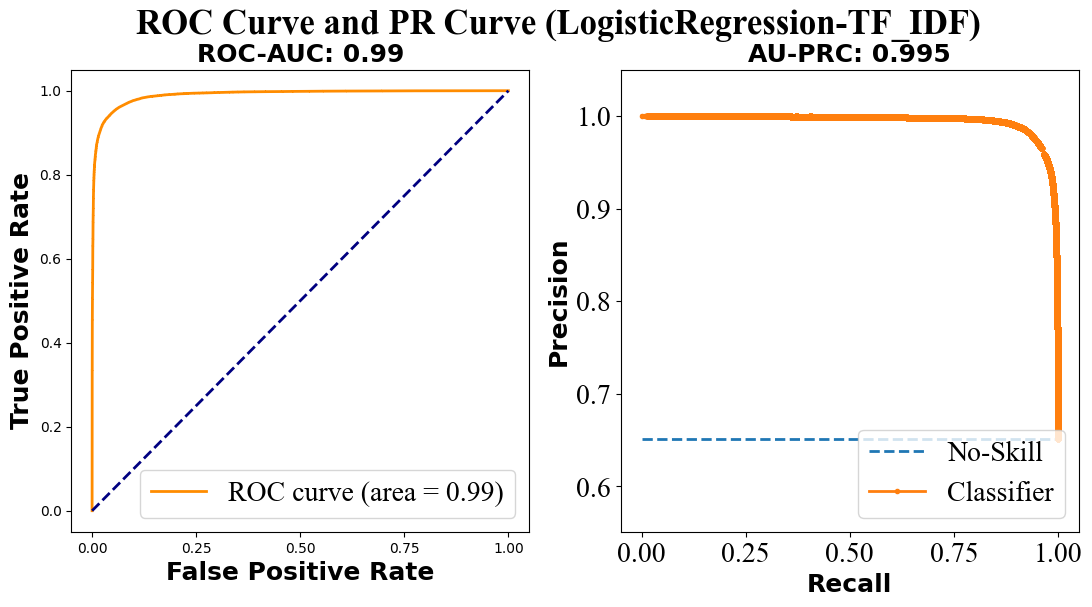

In [11]:
#====================================================================================================#
# TF-IDF Logistic Regression

estimator = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                      ,
                    param_grid   =  param_grid                     ,
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                       , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                           ,
                    X_train      =  X_train_tfidf_selected         ,
                    y_train      =  y_train                        ,
                    X_test       =  X_test_tfidf_selected          ,
                    y_test       =  y_test                         ,
                    )


#### &#10148; Bag of Words Logistic Regression

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: LogisticRegression, vectorizer: BoW.
Optimized Params found by Grid Search:  {'C': 100, 'solver': 'liblinear'}
accuracy_score  : 0.9513
precision_score : 0.9665
recall_score    : 0.9584
f1_score_score  : 0.9624
ROC_AUC         : 0.9482

Confusion Matrix
 [[28861  1907]
 [ 2389 55023]]


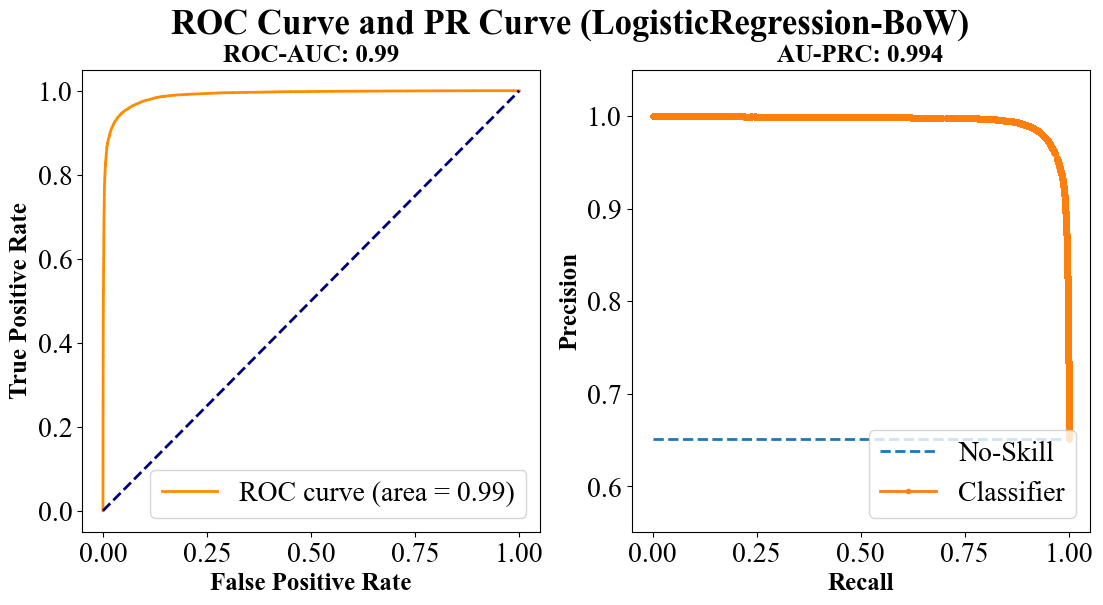

In [12]:
#====================================================================================================#
# Bag of Words Logistic Regression
lr_bow = LogisticRegression
param_grid = {'C': [0.1, 1, 10, 100],
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
LogReg_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  lr_bow                         ,
                    param_grid   =  param_grid                     ,
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                          , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  5000                           ,
                    X_train      =  X_train_bow_selected           ,
                    y_train      =  y_train                        ,
                    X_test       =  X_test_bow_selected            ,
                    y_test       =  y_test                         ,
                    )

#### &#10148; TF-IDF Naive Bayes

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: MultinomialNB, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9072
precision_score : 0.8856
recall_score    : 0.9846
f1_score_score  : 0.9325
ROC_AUC         : 0.8736

Confusion Matrix
 [[23468  7300]
 [  887 56525]]


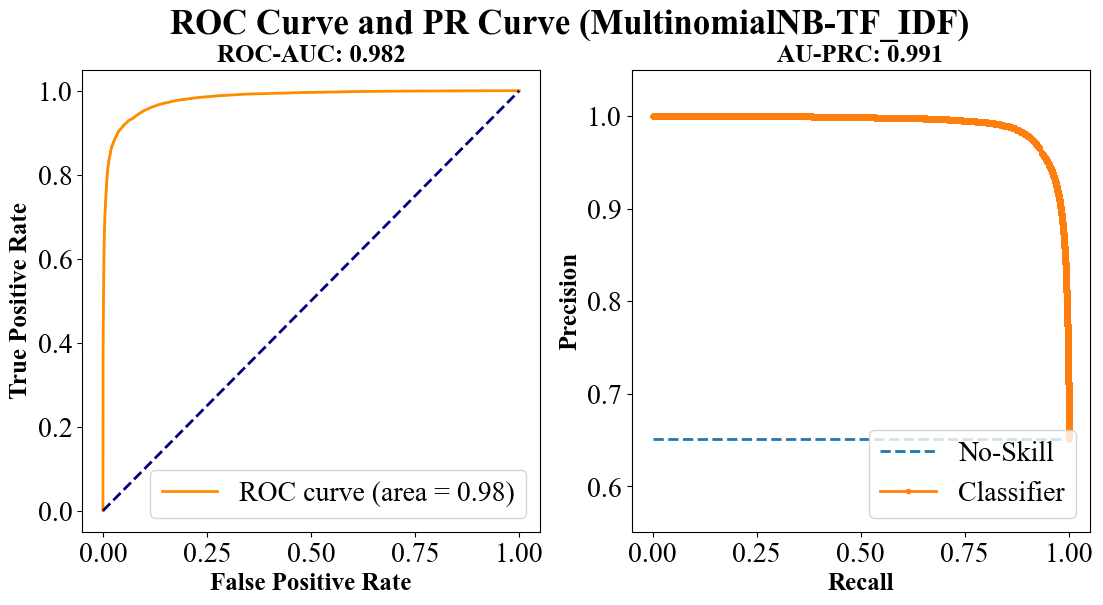

In [13]:
#====================================================================================================#
# TF-IDF Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                      , 
                    param_grid   =  param_grid                     , 
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                       , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                           , 
                    X_train      =  X_train_tfidf_selected         , 
                    y_train      =  y_train                        , 
                    X_test       =  X_test_tfidf_selected          , 
                    y_test       =  y_test                         , 
                    )



#### &#10148; Bag of Words Naive Bayes

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: MultinomialNB, vectorizer: BoW.
Optimized Params found by Grid Search:  {'alpha': 0.1}
accuracy_score  : 0.9378
precision_score : 0.9475
recall_score    : 0.9576
f1_score_score  : 0.9525
ROC_AUC         : 0.9293

Confusion Matrix
 [[27719  3049]
 [ 2433 54979]]


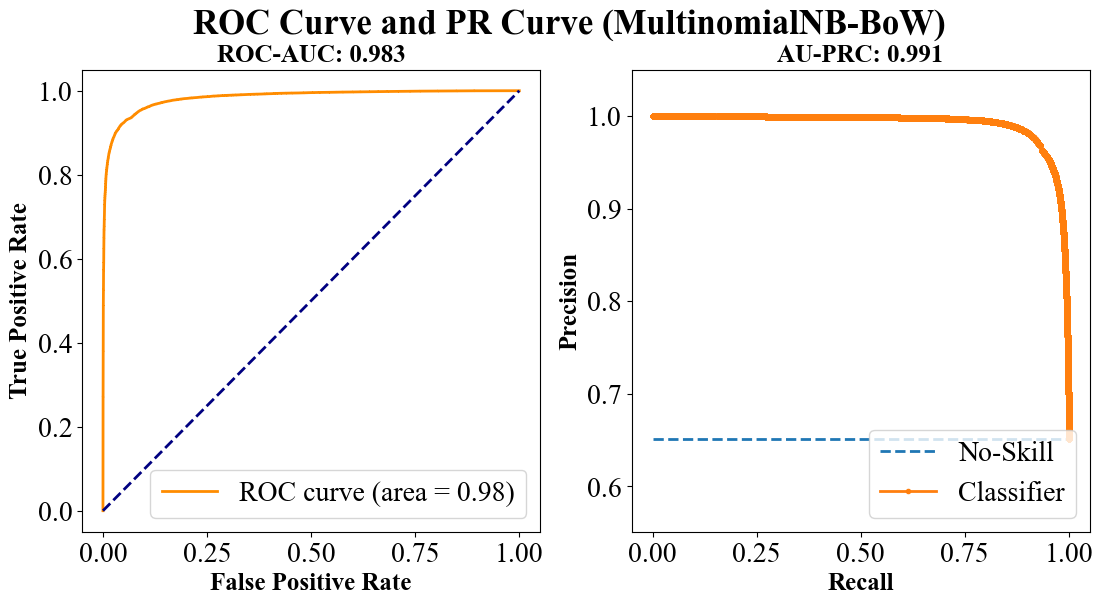

In [14]:
#====================================================================================================#
# Bag of Words Naive Bayes
estimator = MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
NaiveBayes_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                      , 
                    param_grid   =  param_grid                     , 
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                          , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                           , 
                    X_train      =  X_train_bow_selected           ,
                    y_train      =  y_train                        ,
                    X_test       =  X_test_bow_selected            ,
                    y_test       =  y_test                         ,
                    )


#### &#10148; TF-IDF Decision Tree

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: DecisionTreeClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10}
accuracy_score  : 0.7717
precision_score : 0.8904
recall_score    : 0.7404
f1_score_score  : 0.8085
ROC_AUC         : 0.7852

Confusion Matrix
 [[25537  5231]
 [14902 42510]]


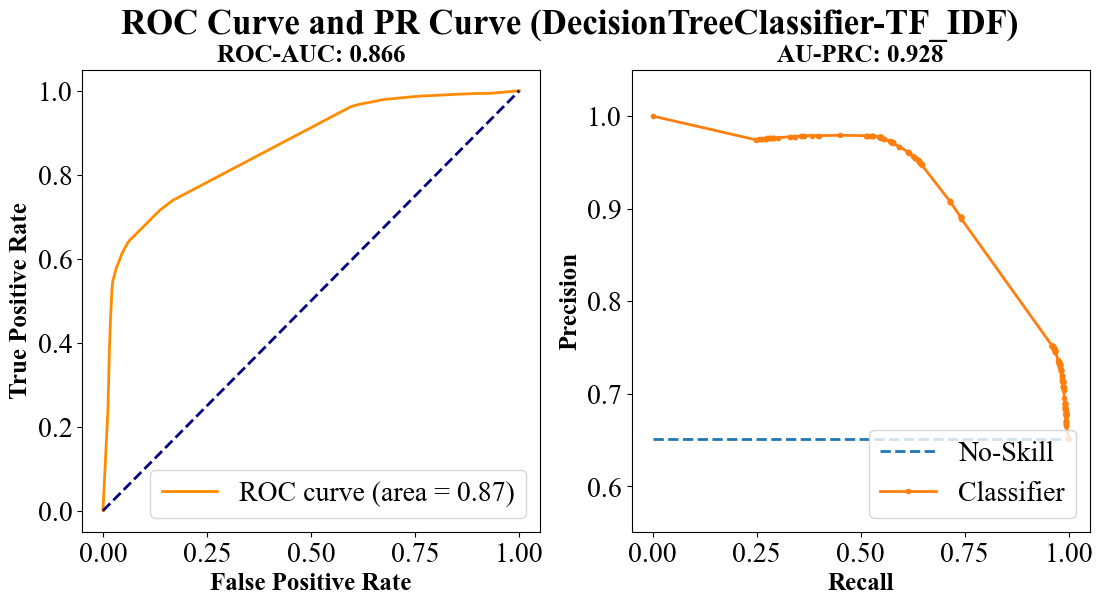

In [15]:
#====================================================================================================#
# TF-IDF Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                      , 
                    param_grid   =  param_grid                     , 
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                       , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                           , 
                    X_train      =  X_train_tfidf_selected         , 
                    y_train      =  y_train                        , 
                    X_test       =  X_test_tfidf_selected          , 
                    y_test       =  y_test                         , 
                    )



#### &#10148; Bag of Words Decision Tree

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: DecisionTreeClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
accuracy_score  : 0.7832
precision_score : 0.7739
recall_score    : 0.9423
f1_score_score  : 0.8498
ROC_AUC         : 0.7143

Confusion Matrix
 [[14960 15808]
 [ 3311 54101]]


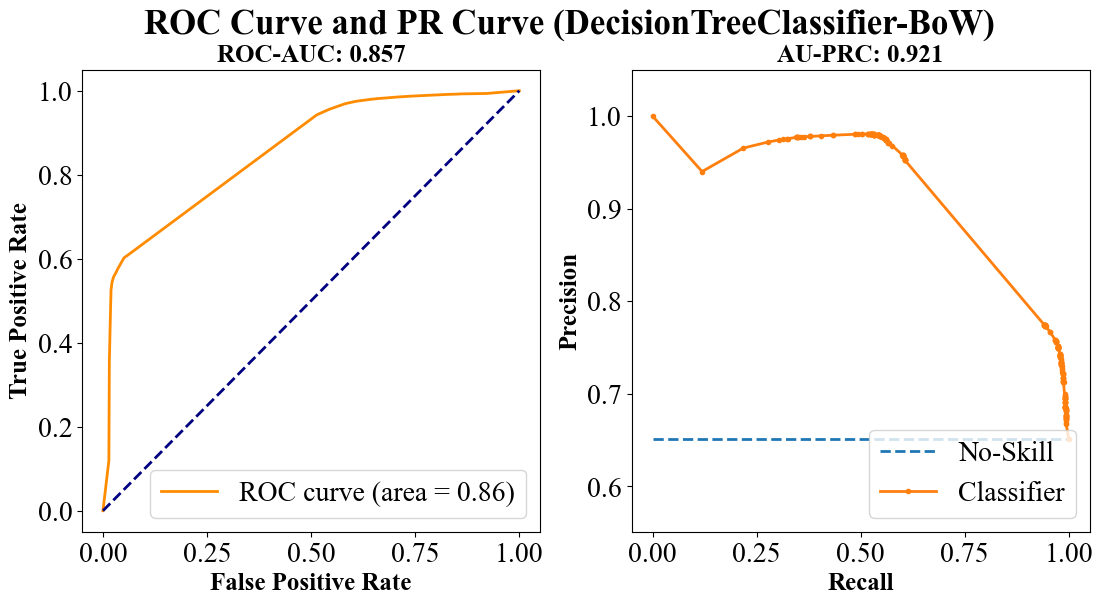

In [16]:
#====================================================================================================#
# Bag of Words Decision Tree
estimator = DecisionTreeClassifier
param_grid = {'max_features': ["sqrt", "log2"], 'max_depth': [10, 20, 50], 'min_samples_split': [2, 5, 10]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
DT_BoW_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                      , 
                    param_grid   =  param_grid                     , 
                    n_jobs       =  -1                             , # Ensure all available processors are used.
                    cv           =  5                              ,
                    scoring      =  'f1_micro'                     , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"   , # Save grid search results. 
                    vectorizer   =  "BoW"                          , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                           , 
                    X_train      =  X_train_bow_selected           ,
                    y_train      =  y_train                        ,
                    X_test       =  X_test_bow_selected            ,
                    y_test       =  y_test                         ,
                    )

#### &#10148; TF-IDF XGBoost

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: XGBClassifier, vectorizer: TF_IDF.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100}
accuracy_score  : 0.7552
precision_score : 0.8381
recall_score    : 0.7735
f1_score_score  : 0.8045
ROC_AUC         : 0.7473

Confusion Matrix
 [[22186  8582]
 [13002 44410]]


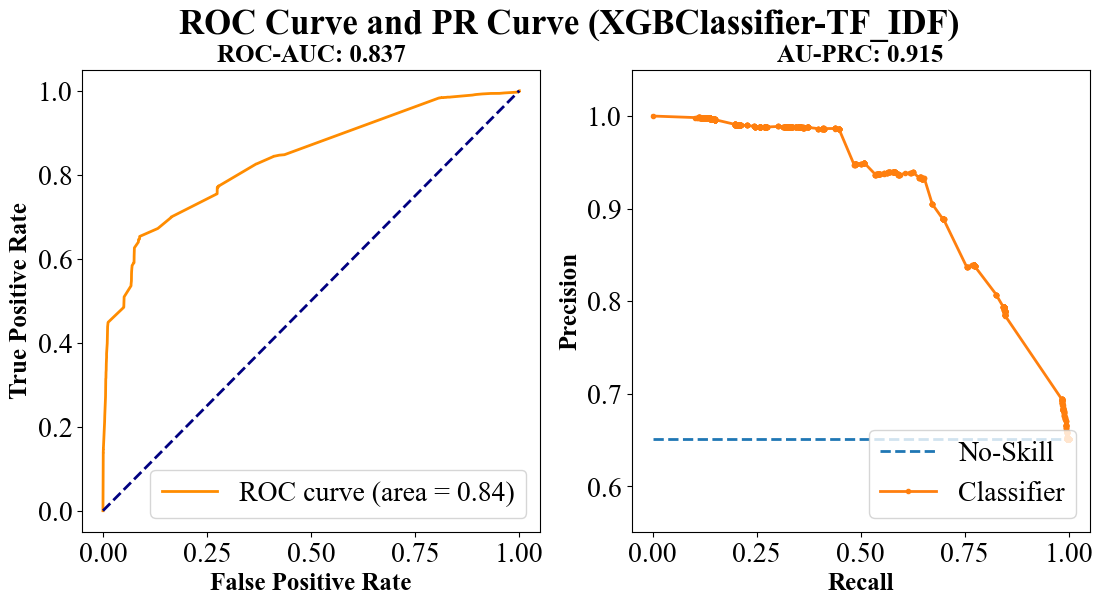

In [17]:
#====================================================================================================#
# TF-IDF XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}

# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      ,
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"           , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_tfidf_selected                 , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_tfidf_selected                  , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

#### &#10148; Bag of Words XGBoost

Previous Grid Search Results found in Saving Files. Skip the Grid Search.
Model: XGBClassifier, vectorizer: BoW.
Optimized Params found by Grid Search:  {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}
accuracy_score  : 0.9512
precision_score : 0.9661
recall_score    : 0.9586
f1_score_score  : 0.9623
ROC_AUC         : 0.9479

Confusion Matrix
 [[28835  1933]
 [ 2374 55038]]


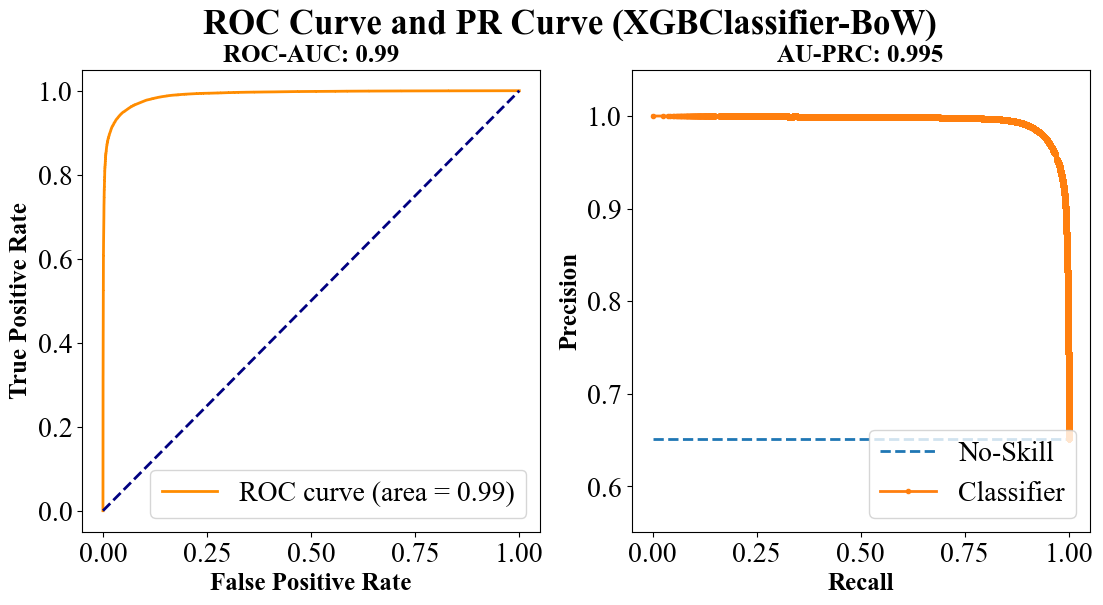

In [18]:
#====================================================================================================#
# Bag of Words XGBoost
estimator = XGBClassifier
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
XGBoost_BoW_Accuracy, GridSearch_results = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      , 
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"           , # Save grid search results. 
                    vectorizer   =  "BoW"                                  , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_bow_selected                   , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_bow_selected                    , 
                    y_test       =  y_test                                 , 
                    extra_params =  {"tree_method":'gpu_hist', "gpu_id":0} , 
                    )

In [19]:
from sklearn.svm import SVC
#====================================================================================================#
# TF-IDF SVC
estimator = SVC
param_grid = {'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
"""
SVC_TFIDF_Accuracy, _ = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      ,
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"           , # Save grid search results. 
                    vectorizer   =  "TF_IDF"                               , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_tfidf_selected                 , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_tfidf_selected                  , 
                    y_test       =  y_test                                 , 
                    )
                    """
                    
#====================================================================================================#
# Bag of Words SVC
estimator = SVC
param_grid = {'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]}


# Evaluate the models (Grid Search for optimized hyperparameters and Report Results on the test set)
"""
SVC_BoW_Accuracy, GridSearch_results = \
GridSearchCV_expand(estimator    =  estimator                              , 
                    param_grid   =  param_grid                             , 
                    n_jobs       =  -1                                     , # Ensure all available processors are used.
                    cv           =  5                                      , 
                    scoring      =  'f1_micro'                             , # Use F1-score as metric.
                    savings      =  "Saving_GridSearchSavings.p"           , # Save grid search results. 
                    vectorizer   =  "BoW"                                  , # assert vectorizer in {"TF_IDF", "BoW"}
                    max_iter     =  None                                   , 
                    X_train      =  X_train_bow_selected                   , 
                    y_train      =  y_train                                , 
                    X_test       =  X_test_bow_selected                    , 
                    y_test       =  y_test                                 , 
                    )
                    """
SVC_TFIDF_Accuracy = 0.0
SVC_BoW_Accuracy   = 0.0


### &#10148; MLP Classifier
- Define a general MLP Classifier
    - Using 3-layer FFNN as architecture.
    - CrossEntropyLoss as Criterion.
    - Output Heatmap that visualize the confusion matrix.

In [26]:
import torch
import torch.optim as optim

from torch import nn
from torch.utils import data

from torch.nn.utils.weight_norm import weight_norm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

def General_MLP_Multi_Classifier( \
        X_train             =     None                         ,
        y_train             =     None                         ,
        X_test              =     None                         ,
        y_test              =     None                         ,
        epoch_num           =     100                          ,
        batch_size          =     1000                         ,
        learning_rate       =     1e-3                         ,
        NUM_CLASSES         =     2                            ,
        hid_1               =     1024                         ,
        hid_2               =     1024                         ,
        hid_3               =     1024                         ,
        drp_r               =     0.5                          ,
        fig_folder          =     Path("./temp")               ,
        output_file_header  =     "MLP_Dataset_0_test_"        ,
        ):
    #====================================================================================================#
    # Variables rename.  
    EPOCHS              =     epoch_num      
    BATCH_SIZE          =     batch_size     
    LEARNING_RATE       =     learning_rate  
    NUM_FEATURES        =     X_train.shape[1]

    #====================================================================================================#
    # Define a dict since classes read by pytorch shall be {0,1,...C-1} (Not Used here)
    def class_idx_conversion_dict(class_list, y_data): 
        class2idx = dict([])
        for idx, one_class in enumerate(class_list):
            class2idx[one_class] = idx
        idx2class = {v: k for k, v in class2idx.items()}
        y_data = [class2idx[one_class] for one_class in y_data]
        return class2idx, idx2class, y_data

    #====================================================================================================#
    # 
    def get_class_distribution(numerical_y_data, class_list = [0,1], ):
        count_dict = {class_x : 0 for class_x in class_list}
        for class_idx in numerical_y_data:
            count_dict[class_list[class_idx]] += 1
        return count_dict

    #====================================================================================================#
    # LoaderClass
    class LoaderClass(Dataset):
        def __init__(self, X_data, y_data):
            super(LoaderClass, self).__init__()
            self.X_data = X_data
            self.y_data = y_data
        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        def __len__ (self):
            return self.X_data.shape[0]
        

    class LoaderClass_LowRAM(Dataset):
        def __init__(self, X_data, y_data):
            super(LoaderClass_LowRAM, self).__init__()
            self.X_data = X_data
            self.y_data = y_data
        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        def __len__ (self):
            return len(self.X_data)
        def collate_fn(self, batch:List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
            X_data, y_data = zip(*batch)
            batch_size = len(X_data)

            return {'X_data': torch.from_numpy(np.array(X_data)), 'y_data': torch.tensor(np.array(list(y_data))) }


    def generate_CNN_loader(X_tr, y_tr,
                            X_va, y_va,
                            X_ts, y_ts,
                            batch_size):
        X_y_tr = LoaderClass_LowRAM(list(X_tr), y_tr)
        X_y_va = LoaderClass_LowRAM(list(X_va), y_va)
        X_y_ts = LoaderClass_LowRAM(list(X_ts), y_ts)
        train_loader = data.DataLoader(X_y_tr, batch_size, True,  collate_fn = X_y_tr.collate_fn)
        valid_loader = data.DataLoader(X_y_va, batch_size, False, collate_fn = X_y_va.collate_fn)
        test_loader  = data.DataLoader(X_y_ts, batch_size, False, collate_fn = X_y_ts.collate_fn)
        return train_loader, valid_loader, test_loader

    #====================================================================================================#
    # Not for Load Data. Other Use.
    # train_dataset = LoaderClass(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    # valid_dataset = LoaderClass(torch.from_numpy(X_test ).float(), torch.from_numpy(y_test) .long())
    # test_dataset  = LoaderClass(torch.from_numpy(X_test ).float(), torch.from_numpy(y_test ).long())

    #--------------------------------------------------#
    target_list = []
    for t in y_train:
        target_list.append(t)
        
    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    print("target_list: ", target_list)

    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype = torch.float) 
    print("class_weights: ", class_weights)

    ##====================================================================================================#
    train_loader, valid_loader, test_loader = \
        generate_CNN_loader(X_train, y_train,
                            X_test , y_test ,
                            X_test , y_test ,
                            batch_size)

    #====================================================================================================#
    # A MLP Classifier.
    class MulticlassClassification(nn.Module):
        def __init__(self, 
                    num_feature, 
                    num_class,
                    hid_1,
                    hid_2,
                    hid_3,
                    drp_r,
                    ):
            super(MulticlassClassification, self).__init__()
            
            self.layer_1 = nn.Linear(num_feature, hid_1)
            self.layer_2 = nn.Linear(hid_1, hid_2)
            self.layer_3 = nn.Linear(hid_2, hid_3)
            self.layer_out = nn.Linear(hid_3, num_class) 
            
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=drp_r)
            self.batchnorm1 = nn.BatchNorm1d(hid_1)
            self.batchnorm2 = nn.BatchNorm1d(hid_2)
            self.batchnorm3 = nn.BatchNorm1d(hid_3)
            
        def forward(self, x):
            x = self.layer_1(x)
            x = self.batchnorm1(x)
            x = self.relu(x)
            
            x = self.layer_2(x)
            x = self.batchnorm2(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.layer_3(x)
            x = self.batchnorm3(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.layer_out(x)
            
            return x

    #====================================================================================================#
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #====================================================================================================#
    # 
    model = MulticlassClassification(NUM_FEATURES, 
                                    NUM_CLASSES,
                                    hid_1,
                                    hid_2,
                                    hid_3,
                                    drp_r,
                                    )
    model.to(device)
    criterion = nn.CrossEntropyLoss( weight = class_weights.to(device) )
    #criterion = nn.CrossEntropyLoss( )
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print(model)


    #====================================================================================================#
    # 
    def multi_acc(y_pred, y_test):
        y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
        correct_pred = (y_pred_tags == y_test).float()
        acc = correct_pred.sum() / len(correct_pred)
        acc = torch.round(acc * 100)
        return acc

    #====================================================================================================#
    # Define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

    accuracy_stats = {'train': [], "valid": [] }
    loss_stats     = {'train': [], "valid": [] }

    #====================================================================================================#
    # 
    print("Begin training.")
    for epoch in range(1, EPOCHS+1):
        #--------------------------------------------------#
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for one_x_y_group in train_loader:
            input_vars = [one_x_y_group[one_var] for one_var in ["X_data",]]
            input_vars = input_vars[0].float().to(device)
            X_train_batch = input_vars
            y_train_batch = one_x_y_group["y_data"].long().to(device)
            #--------------------------------------------------#
            optimizer.zero_grad()
            #--------------------------------------------------#
            y_train_pred = model(X_train_batch)
            #--------------------------------------------------#
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            #--------------------------------------------------#
            train_loss.backward()
            optimizer.step()
            #--------------------------------------------------#
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        
        
        #--------------------------------------------------#
        # VALIDATION    
        with torch.no_grad():
            #--------------------------------------------------#
            valid_epoch_loss = 0
            valid_epoch_acc = 0
            #--------------------------------------------------#
            model.eval()
            for one_x_y_group in valid_loader:
                input_vars = [one_x_y_group[one_var] for one_var in ["X_data"]]
                input_vars = input_vars[0].float().to(device)
                X_valid_batch = input_vars
                y_valid_batch = one_x_y_group["y_data"].long().to(device)
                #--------------------------------------------------#
                y_valid_pred = model(X_valid_batch)
                #--------------------------------------------------#         
                valid_loss = criterion(y_valid_pred, y_valid_batch)
                valid_acc = multi_acc(y_valid_pred, y_valid_batch)
                #--------------------------------------------------#
                valid_epoch_loss += valid_loss.item()
                valid_epoch_acc  += valid_acc.item()
        #--------------------------------------------------#
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['valid'].append(valid_epoch_loss/len(valid_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['valid'].append(valid_epoch_acc/len(valid_loader))
        

        #--------------------------------------------------#
        # TESTING 
        y_pred_list = []
        with torch.no_grad():
            #--------------------------------------------------#
            model.eval()
            for one_x_y_group in test_loader:
                input_vars = [one_x_y_group[one_var] for one_var in ["X_data"]]
                input_vars = input_vars[0].float().to(device)
                X_test_batch = input_vars
                y_test_pred = model(X_test_batch)
                _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                y_pred_list.append(y_pred_tags.cpu().numpy())
            #--------------------------------------------------#
            y_pred_list = np.concatenate(y_pred_list)
            #--------------------------------------------------#
            cm = confusion_matrix(y_test, y_pred_list)
            confusion_matrix_df = pd.DataFrame(cm) #.rename(columns = idx2class, index = idx2class)
            #--------------------------------------------------#
            fig = plt.figure(figsize=(6,4.8))
            #g = sns.heatmap(confusion_matrix_df, cmap="Reds", center=550, annot=True, fmt="d")
            g = sns.heatmap(confusion_matrix_df, cmap="magma", annot=True, fmt="d")
            g.set(xlabel="")
            # plt.show()
            #--------------------------------------------------#
            fig.savefig(fig_folder / (output_file_header + "epoch_" + str(epoch) + "_") , dpi=1000 )
            #mpl.rcParams.update(mpl.rcParamsDefault)
            plt.close("all")

        print(f'   Epoch {epoch+0:03}: \
            | Train Loss: {train_epoch_loss/len(train_loader):.5f} \
            | Valid Loss: {valid_epoch_loss/len(valid_loader):.5f} \
            | Train Acc: {train_epoch_acc/len(train_loader):.3f}   \
            | Valid Acc: {valid_epoch_acc/len(valid_loader):.3f}'   )
        
    return 
    



### &#10148; Reload Data and include more features (up to 10000) 
- (Requires 90GB RAM since the function is not optimized)

In [23]:
#====================================================================================================#
# Teload Data.
X_data = df['cleaned_text'].values.tolist()
y_data = df['label']       .values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1624)

#====================================================================================================#
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

#====================================================================================================#
# Bag of Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# select 1000 best features by chi2
#====================================================================================================#
# TF-IDF
k = 10000 
selector = SelectKBest(chi2, k = k)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

#====================================================================================================#
# Bag of Words
selector = SelectKBest(chi2, k = k)
X_train_bow_selected = selector.fit_transform(X_train_bow, y_train)
X_test_bow_selected = selector.transform(X_test_bow)



In [27]:


#====================================================================================================#
# Data
X_train_MLP = X_train_tfidf_selected.toarray()
y_train_MLP = np.array(y_train)                
X_test_MLP  = X_test_tfidf_selected.toarray()
y_test_MLP  = np.array(y_test)                 
#====================================================================================================#
# Settings
EPOCHS              =     epoch_num                       = 10
BATCH_SIZE          =     batch_size                      = 1000
LEARNING_RATE       =     learning_rate                   = 1e-4
NUM_FEATURES        =     X_train_bow_selected.shape[1]
NUM_CLASSES         =     2
hid_1               =     1024
hid_2               =     1024
hid_3               =     1024
drp_r               =     0.1
fig_folder          =     Path("./temp")
output_file_header  =     "MLP_Dataset_0_test_"

#====================================================================================================#
# Skip Training The model. 
"""
General_MLP_Multi_Classifier( \
    X_train             =     X_train_MLP                  ,
    y_train             =     y_train_MLP                  ,
    X_test              =     X_test_MLP                   ,
    y_test              =     y_test_MLP                   ,
    epoch_num           =     10                           ,
    batch_size          =     1000                         ,
    learning_rate       =     1e-3                         ,
    NUM_CLASSES         =     2                            ,
    hid_1               =     1024                         ,
    hid_2               =     1024                         ,
    hid_3               =     1024                         ,
    drp_r               =     0.5                          ,
    fig_folder          =     Path("./temp")               ,
    output_file_header  =     "MLP_Dataset_0_test_TFIDF_"  ,
    )
    """

target_list:  tensor([1, 1, 1,  ..., 1, 0, 1], dtype=torch.int32)
class_weights:  tensor([8.0870e-06, 4.3656e-06])
cuda:0
MulticlassClassification(
  (layer_1): Linear(in_features=10000, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_out): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.
   Epoch 001:             | Train Loss: 0.11064             | Valid Loss: 0.09477             | Train Acc: 95.640               | Valid Acc: 96.281
   Epoch 002:             | Train Loss: 0.06396             

In [28]:
# 
#====================================================================================================#
# Data
X_train_MLP = X_train_bow_selected.toarray()
y_train_MLP = np.array(y_train)                
X_test_MLP  = X_test_bow_selected.toarray()
y_test_MLP  = np.array(y_test)                 
#====================================================================================================#
# Settings
EPOCHS              =     epoch_num                       = 10
BATCH_SIZE          =     batch_size                      = 1000
LEARNING_RATE       =     learning_rate                   = 1e-4
NUM_FEATURES        =     X_train_bow_selected.shape[1]
NUM_CLASSES         =     2
hid_1               =     1024
hid_2               =     1024
hid_3               =     1024
drp_r               =     0.1
fig_folder          =     Path("./temp")
output_file_header  =     "MLP_Dataset_0_test_"

#====================================================================================================#
General_MLP_Multi_Classifier( \
    X_train             =     X_train_MLP                  ,
    y_train             =     y_train_MLP                  ,
    X_test              =     X_test_MLP                   ,
    y_test              =     y_test_MLP                   ,
    epoch_num           =     10                           ,
    batch_size          =     1000                         ,
    learning_rate       =     1e-3                         ,
    NUM_CLASSES         =     2                            ,
    hid_1               =     1024                         ,
    hid_2               =     1024                         ,
    hid_3               =     1024                         ,
    drp_r               =     0.5                          ,
    fig_folder          =     Path("./temp")               ,
    output_file_header  =     "MLP_Dataset_0_test_BoW_"    ,
    )

target_list:  tensor([1, 0, 1,  ..., 1, 1, 0], dtype=torch.int32)
class_weights:  tensor([8.0870e-06, 4.3656e-06])
cuda:0
MulticlassClassification(
  (layer_1): Linear(in_features=10000, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer_out): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.
   Epoch 001:             | Train Loss: 0.10781             | Valid Loss: 0.08924             | Train Acc: 95.813               | Valid Acc: 96.809
   Epoch 002:             | Train Loss: 0.05795             

### &#10148; Put Together All Results
- Report the best model
    - Hyperparameters
    - Model Performance

In [24]:
#====================================================================================================#
# 
print("Logistic Regression Accuracy     - TF-IDF: {:.4f}, BoW: {:.4f}".format(LogReg_TFIDF_Accuracy      , LogReg_BoW_Accuracy      ))
print("Naive Bayes Accuracy             - TF-IDF: {:.4f}, BoW: {:.4f}".format(NaiveBayes_TFIDF_Accuracy  , NaiveBayes_BoW_Accuracy  ))
print("Decision Tree Accuracy           - TF-IDF: {:.4f}, BoW: {:.4f}".format(DT_TFIDF_Accuracy          , DT_BoW_Accuracy          ))
print("XGBoost Accuracy                 - TF-IDF: {:.4f}, BoW: {:.4f}".format(XGBoost_TFIDF_Accuracy     , XGBoost_BoW_Accuracy     ))
print("SupportVectorClassifier Accuracy - TF-IDF: {:.4f}, BoW: {:.4f}".format(SVC_TFIDF_Accuracy         , SVC_BoW_Accuracy         ))

optimized_params = GridSearch_results[("XGBClassifier", "BoW")]

print("\nSummary: XGBClassifier with Bag of Words has the best accuracy. ")
print(f"Grid Search has found best parameters for the model are, {optimized_params}")

Logistic Regression Accuracy     - TF-IDF: 0.9513, BoW: 0.9513
Naive Bayes Accuracy             - TF-IDF: 0.9072, BoW: 0.9378
Decision Tree Accuracy           - TF-IDF: 0.7999, BoW: 0.8124
XGBoost Accuracy                 - TF-IDF: 0.7552, BoW: 0.9512
SupportVectorClassifier Accuracy - TF-IDF: 0.0000, BoW: 0.0000

Summary: XGBClassifier with Bag of Words has the best accuracy. 
Grid Search has found best parameters for the model are, {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}


### &#10148; All Model Settings (Hyperparameters)

In [25]:
XGBClassifier(learning_rate= 0.5, max_depth= 10, n_estimators= 500)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# &#10004; **Part 2**

### &#10148; Get a Trained Sentiment Binary Classifier based on Analysis in Part 1
- Get the best-performed model from Part 1 (i.e., XGBClassifier).
- Prepare the data in the same way as Part 1 (Clean the Text).
- Apply the same feature selector and vectorizer as Part 1 (i.e., Chi2).
- Train the best-performed model with entire processed dataset (using BoW as Vectorizer).

In [26]:
#====================================================================================================#
# Get the best-performed model from Part 1
Sentiment_Binary_Classifier_Part1 = XGBClassifier(learning_rate = 0.5        , 
                                                  max_depth     = 10         , 
                                                  n_estimators  = 500        , 
                                                  random_state  = 1624       ,
                                                  tree_method   = 'gpu_hist' , 
                                                  gpu_id        = 0          ,
                                                  )
#====================================================================================================#
# Skip the data processing step (since Part 1 & 2 is combined).
# Can Copy and Paste Data Processing Step to Here.


#====================================================================================================#
# Prepare Machine Learning-Ready Dataset. 
# Vectorizer - Bag of Words.
vectorizer = CountVectorizer()
X_data_bow = vectorizer.fit_transform(X_data)
#--------------------------------------------------#
# Select feature using the same selector in Part 1. 
selector = SelectKBest(chi2, k = 1000)
X_data_bow_selected = selector.fit_transform(X_data_bow, y_data)

#====================================================================================================#
# Use the entire dataset to train the best model we have from Part 1. 
Sentiment_Binary_Classifier_Part1.fit(X_data_bow_selected, y_data) 

print("Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. ")



Sentiment_Binary_Classifier_Part1 is Trained on the entire sentiment analysis dataset. 


### &#10148; Processed the dataset to be studied in Part 2
- Load Part 2 dataset #1 - reddit_raw_ukraine_russia.csv

In [27]:
#====================================================================================================#
# Load data
data_folder = Path("./data_folder")
data_file_1   = "Part_2_Dataset_1_reddit_raw_ukraine_russia.csv"


#====================================================================================================#
# Load data with "ISO-8859-1" encoding.
df_raw_1 = pd.read_csv(filepath_or_buffer   =   data_folder/data_file_1           ,
                       header               =   0                                 , 
                       index_col            =   0                                 ,
                       encoding             =   "ISO-8859-1"                      ,
                       sep                  =   ','                               ,  
                       low_memory           =   False                             , )

# Print dimension of the raw data.
print("\nRaw dataset printed below: (Only showing useful columns)")
print("df_raw_1.shape: ", df_raw_1.shape) # 4 columns. 
df_raw_1 = df_raw_1.drop(columns=["date", "post_id", "comment_id"]) # Remove Useless columnns directly.
print(df_raw_1.head(5))




Raw dataset printed below: (Only showing useful columns)
df_raw_1.shape:  (16707, 4)
                                            comments
0  Hello /u/hjgbuijhgh,\n\nThis community is focu...
1  uhm thats quite the increase.  \n\n\nI also he...
2  Poland also announced that they plan to double...
3  Remember, NATO knows more than weâre being t...
4  Well done, Putin. Top 2022 salesman of NATO. \...


### &#10148; Will have to Load spaCy again because you always have to do weird things with spaCy.

In [40]:
#====================================================================================================#
# Check the string is English or NOT. (using the ``spaCy`` package)
# Can also use `TextBlob` or `Pycld2` but I dont want to use google API.
print("\n``spaCy`` is used to detect language. Need to, \n(1)install ``spaCy`` \n(2)Download models via")
print("    python -m spacy download en_core_web_lg")
print("    python -m spacy download en_core_web_sm")
# !pip install spacy
# !pip install spacy_langdetect
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf
#--------------------------------------------------#
# Prepares
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
def get_lang_detector(nlp, name):
    return LanguageDetector(seed = 42)
# Language Factory cannot be loaded multiple times for no reason.
# Therefore, have to use try/except block.
try:
    Language.factory("language_detector", func = get_lang_detector)
except:
    pass
nlp.add_pipe('language_detector', last = True)
#--------------------------------------------------#
# Define a function for identifying language (whether English).
def is_English(text_str):
    doc = nlp(text_str)
    detect_language = doc._.language["language"] 
    score           = doc._.language["score"]
    return (detect_language == "en"), detect_language, score

def is_English_batch_process(text_list):
    ifEnglish_list = []
    dtct_lang_list = []
    score_list = []
    for idx, doc in enumerate(nlp.pipe(text_list, n_process = 4, batch_size = 2000)):
        lang_detect_result = doc._.language
        detect_language    = lang_detect_result["language"] 
        score              = lang_detect_result["score"]
        ifEnglish_list.append(detect_language == "en")
        dtct_lang_list.append(detect_language)
        score_list    .append(score)
    return ifEnglish_list, dtct_lang_list, score_list

is_English("Languages identified by spaCy")
is_English_batch_process(["is_English_batch_process", "All English text identified as rare languages"])


``spaCy`` is used to detect language. Need to, 
(1)install ``spaCy`` 
(2)Download models via
    python -m spacy download en_core_web_lg
    python -m spacy download en_core_web_sm


([True, True], ['en', 'en'], [0.9999975192270886, 0.9999969283680661])

### &#10148; Clean the text data (with help of previously defined functions)

In [55]:
# Use the list of functions above to clean the raw text.
#====================================================================================================#
# Get a copy of the raw.
df_cleaned_1 = copy.deepcopy(df_raw_1) 

# Drop nan values in the columns.
df_cleaned_1 = df_cleaned_1.dropna()

# Clean.
df_cleaned_1['cleaned_text'] = df_cleaned_1['comments']
df_cleaned_1 = df_cleaned_1.drop(columns=["comments"])

#====================================================================================================#
# Identify language.
#   - Use a saved processed dataframe if found in the savings, otherwise generate a new one. 
#   - Takes 1 min 30 sec on a 5800X CPU.
if os.path.exists("./Saving_df_cleaned_1_all.p"):
    df_cleaned_1_all = pd.read_pickle("./Saving_df_cleaned_1_all.p")
else:
    df_cleaned_1_all = df_cleaned_1.copy(deep = True)
    all_text = df_cleaned_1_all["cleaned_text"].values.tolist()
    English_Check_output = is_English_batch_process(all_text)
    df_cleaned_1_all["If_Eng"]   = English_Check_output[0]
    df_cleaned_1_all["Language"] = English_Check_output[1]
    df_cleaned_1_all["score"]    = English_Check_output[2]
    df_cleaned_1_all.to_pickle("./Saving_df_cleaned_1_all.p")

print("\nLanguages identified by spaCy: ")
print("All English text identified as rare languages (that have been checked) are ")
print("confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. ")
print("Whether to remove these data is optional, since the number is negligible. ")
#print(df_cleaned_1_all['Language'].value_counts().head(10))

df_cleaned_1_eng = df_cleaned_1_all[df_cleaned_1_all.If_Eng == True]
df_cleaned_0_non_en = df_cleaned_0_all.loc[(df_cleaned_0_all["If_Eng"] == False) & (df_cleaned_0_all["Score"] > 0.999) ]
# print("\nSome identified non-English text printed below: ")
# print(df_cleaned_0_non_en["cleaned_text"].head(5))

# If using ASCII_only_string, 2000 records will be removed 
# (likely to be English comments including non-ASCII chars.)
#df_cleaned_1_eng = df_cleaned_1_all[df_cleaned_1_all.comments.map(lambda x : is_ASCII_only_string(x))]

# Clean text.
df_cleaned_1_all['cleaned_text'] = df_cleaned_1_all['cleaned_text'].apply(clean_text).apply(clean_text_preproc)
df_cleaned_1_eng['cleaned_text'] = df_cleaned_1_eng['cleaned_text'].apply(clean_text).apply(clean_text_preproc)

#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
print("\nCheck for duplicates (mostly deleted/short answer): ")
#print(df_cleaned_1_all['cleaned_text'].value_counts().head(5)) # Lots of duplciates
# DROP DUPLICATES
df_cleaned_1_all = df_cleaned_1_all.drop_duplicates(subset = ['cleaned_text'], keep = 'first')

#====================================================================================================#
# Clean and format the filtered English text data. (DROP DUPLICATES !!)
# Check duplicates
text_list = df_cleaned_1_all['cleaned_text'].values.tolist()
for text_x in text_list:
    if len(text_x) == 1 or text_x == "" or text_x == "thank you" or text_x.count(" ") == 0:
        # Remove one-word answer. May contain sentiment but require context to understand exact meaning.
        # Even two-words can be meaningful. For example, fuck p***n.
        print(text_x, end = " | ")
        text_list.remove(text_x)
    if text_x.find("i am a bot") != -1: # Remove bot messages.
        text_list.remove(text_x)
    
    # Removing all short answer can be a option.
    """
    if text_x.count(" ") <= 2:
        text_list.remove(text_x)
    """



print(f"\nA short summary of cleaning the text data: ")
print(f"\tThe raw dataset contains {df_cleaned_1.shape[0]} instances. " )
print(f"\tAfter clean the data, remove duplicates and meaningless answers, {len(text_list)} instances are left. ")

print("\nDataframe with cleaned text data printed out below. ")
df_cleaned_1_all = pd.DataFrame(text_list, columns =['cleaned_text'])
df_cleaned_1_all.head(5)




Languages identified by spaCy: 
All English text identified as rare languages (that have been checked) are 
confirmed to be FALSEly detected as non-English, but are mostly data with low-quality. 
Whether to remove these data is optional, since the number is negligible. 

Check for duplicates (mostly deleted/short answer): 
based | removed | deleted | true | haha | why | rcivpolitics | yep | bhlz4 | unfortunately | lmao | ereh | rshitamericanssay |  | rshermanposting | wooloolooo | genghster | land | kyiv | elections | christ | yes | second | samesies | thank you | fourth | fifth | oh | sixth | eighth | good | exactly | wapo | propaganda | rekteconomy | end2021locationsrustart1990viewchart | correct | who | triggered | 30475 | what | lol | 1000casualtiesdaydonbasarakhamia | meh | stop | imgemotet52qqcn9004 | ouch | l | 1984 | absolutely | hahahahahahahahaha | thanks | obvious | nukes | ditto | obviously | lold | thismorningafterbidensignslendleasethismorningafterbidensignslendleaserele

,cleaned_text
0,uhm thats quite the increase i also heared the...
1,poland also announced that they plan to double...
2,remember nato knows more than were being told ...
3,well done putin top 2022 salesman of nato befo...
4,very good decision russians are incapable of u...


### &#10148; Get Pretrained Sentiment Analysis Model, Vader
- Vader returns a set of scores for text data.
- These scores of sentiment reflect the estimated likelihood of the text being 
    - positive
    - negative
    - neutral (respectively)
- There is also a "Compound" Score that is estimated based on combining all three scores. 

In [60]:
# from typing import Optional, Union, Tuple, Type, Sequence, List, Set, Any, TextIO, IO
def Vader_Prediction( text_array, threshold = 0.05, model = SentimentIntensityAnalyzer() ):
    """
    Inputs - threshold:
        - Typical threshold values (used in the literature cited on this page) are:
            * positive sentiment: (compound score >= +0.05)
            * neutral  sentiment: (compound score >  -0.05) and (compound score <  +0.05)
            * negative sentiment: (compound score <= -0.05)
        - Using a standardized threshold for compound score is kept as an option.
    Inputs - model: 
        - no other options. 
    
    Outputs: 
        - list of labels. 
    
    See more details here https://github.com/cjhutto/vaderSentiment#About-the-Scoring.
    """
    sentiment_label_list = []
    for idx, text_x in enumerate(text_array): # Seems that Vader has no batch processig (in parallel) options.
        
        cmpd_score = model.polarity_scores(text_x)['compound']
        if   cmpd_score >=  threshold:
            sentiment_label_list.append("pos")
        elif cmpd_score <= -threshold:
            sentiment_label_list.append("neg")
        else:
            sentiment_label_list.append("neu")
    return sentiment_label_list

In [123]:
# Apply a pretrained model Vader and compute a threshold.
def Vader_pre_label(df, column):
    df1=df.copy(deep=True)
    model = SentimentIntensityAnalyzer()
    df_pred = [*df1[column].apply(model.polarity_scores)]
    neglst = []
    neulst = []
    poslst = []
    compoundlst = []
    for i in df_pred:
        neglst.append(i['neg'])
        poslst.append(i['pos'])
        neulst.append(i['neu'])
        compoundlst.append(i['compound'])
    dfpred = pd.DataFrame({'neg':neglst, 'pos':poslst,'neu': neulst, 'compound': compoundlst})
    df1['compound'] = dfpred['compound'].tolist()
    df1 = df1.dropna()
    threshold = df1['compound'].mean()
    print(threshold)
     # compute y-labels using pretrain model
    df1['label'] = 0
    df1.loc[df1['compound'] >= threshold, 'label'] = 1
    return df1

### &#10148; Vader Prediction
- Apply Pretrained Vader model on the cleaned text data to generate label for each comment.
- Check the distribution of the labels. 
- Adjust the threshold settings in the Vader_Prediction function accordingly.

In [64]:
# Make a copy.
df_cleaned_1_analysis = copy.deepcopy(df_cleaned_1_all)
df_cleaned_1_analysis["predicted_sentiment"] = Vader_Prediction(df_cleaned_1_analysis["cleaned_text"].values.tolist())




'well done putin top 2022 salesman of nato before this stupid cruel war germany didnt want anything to do with nato the bundeswehr was underfunded and the population didnt care for soldiers poland started to push against the eu orban was openly speaking out against the entire eu project spain had troubles of possible sedition catalans the entire peace project between natoeu states was slowly crumbling europe lacked a common goal something they could all rally behind financial prosperity was no longer enough member states didnt want to pay for military they had their naive bubble that europe would stay at peace foreverand now putin managed to unite the entirety of europe nato is stronger than ever before whatever putin tried to achieve he failed russia is weak their military is a joke compared to the entirety of nato ukraine is a relatively small country with no navy little high tech gear all they have is an iron will and the passion to defend their homeland from evil and the superpower

### Prediction

In [128]:
#Vader--English comments
df, column = newdata1_eng, 'comments'
dfnew1_eng = Vader_pre_label(df, column)

dfnew1_eng_c = dfnew1_eng['comments'] # select the column 'comments' of new dataset1(English)
# Bag of Words--English comments
dfnew1_eng_c = vectorizer.transform(dfnew1_eng_c)
dfnew1_eng_c = selector.transform(dfnew1_eng_c)

pred1_eng = xgbbest.predict(dfnew1_eng_c) # return y prediction values of new dataset1(English)

-0.06999917588375625


In [129]:
#Vader--English comments
df,column = newdata1_all, 'comments'
dfnew1_all = Vader_pre_label(df,column)
dfnew1_all_c = dfnew1_all['comments'] # select the column 'comments' of new dataset1 (all languages)

# Bag of Words--All comments
dfnew1_all_c = vectorizer.transform(dfnew1_all_c)
dfnew1_all_c = selector.transform(dfnew1_all_c)

pred1_all = xgbbest.predict(dfnew1_all_c) # return y prediction values of new dataset1(all languages)

-0.07447011432333753


In [130]:
# compute accuracy between pretrained model and xgboost model
allv = dfnew1_all['label'].tolist()
allxb = pred1_all.tolist()
engv = dfnew1_eng['label'].tolist()
engxb = pred1_eng.tolist()
print('All language accuracy: {} \nEnglish only accuracy: {}'.format(accuracy_score(allv, allxb),accuracy_score(engv, engxb)))

All language accuracy: 0.5954988926797151 
English only accuracy: 0.5893876960890624


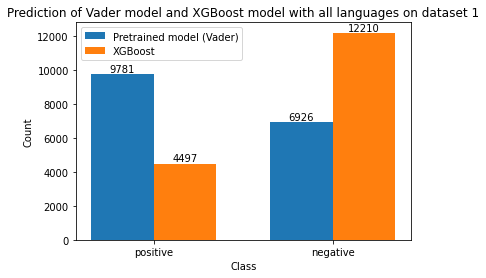

In [131]:
import matplotlib.pyplot as plt

labels = ['positive', 'negative']
values1 = [len([x for x in allv if x == 1]), 
           len([x for x in allv if x == 0])]
values2 = [len([x for x in allxb if x == 1]),
           len([x for x in allxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()


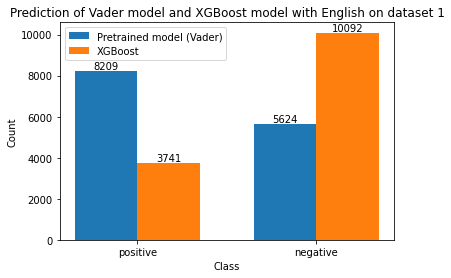

In [132]:
labels = ['positive', 'negative']
values3 = [len([x for x in engv if x == 1]), 
           len([x for x in engv if x == 0])]
values4 = [len([x for x in engxb if x == 1]),
           len([x for x in engxb if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p3 = plt.bar(labels, values3, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p4 = plt.bar([i + width for i in range(len(values4))], values4, width, label='XGBoost')
plt.bar_label(p3)
plt.bar_label(p4)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with English on dataset 1')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()

## New dataset 2 -russian_invasion_of_ukraine.csv

In [133]:
file_2='/content/gdrive/MyDrive/russian_invasion_of_ukraine.csv'

df_inv_tmp=pd.read_csv(file_2, header=[0])

In [134]:
df_inv_tmp.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Live updates: Russians destroy Chernobyl labor...,56,tkjwjl,https://www.washingtonpost.com/politics/live-u...,15.0,1.648003e+09,NaN,2022-03-23 02:34:15
1,Romania Is Handing Out 30 Million Anti-Radiati...,265,tkjqga,https://www.vice.com/amp/en/article/pkpw7b/iod...,22.0,1.648002e+09,NaN,2022-03-23 02:25:07
2,Oil rises towards $116 as EU weighs Russian ban,28,tk1utj,https://www.reuters.com/business/energy/oil-op...,2.0,1.647952e+09,NaN,2022-03-22 12:27:29
3,Russia Sends $66 Million Coupon to Depository ...,44,tk1nlm,https://www.bloomberg.com/news/articles/2022-0...,8.0,1.647951e+09,NaN,2022-03-22 12:17:29
4,Ukraine war latest: Global diesel shortage loo...,31,tk1ky3,https://www.ft.com/content/795b432f-b189-4c91-...,3.0,1.647951e+09,NaN,2022-03-22 12:13:26


In [135]:
#Keep the comments part
df_inv=df_inv_tmp[['body']].dropna()
#Convert the datatype to String
df_inv['body'] = df_inv['body'].astype(str)
#Apply the text cleaning function
df_inv['cleaned_text'] = df_inv['body'].apply(clean_text)

In [136]:
df_inv

,body,cleaned_text
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...
13,Russia: 🥺,russia
...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...


In [137]:
#Check language
df_inv_eng = df_inv['cleaned_text'][df_inv['cleaned_text'].map(lambda x:is_ASCII_only_string(x))]

In [138]:
#Check if there are other languages, if True, the comments text all considered English
print(df_inv_eng.shape[0]==df_inv.shape[0])

True


### Prediction

In [139]:
# XGBoost with Bag of Words
df_inv_bow = vectorizer.transform(df_inv['cleaned_text'])
df_inv_bow_selected = selector.transform(df_inv_bow)
#Predict labels using the best model
df_inv_bow_xgbpred=xgbbest.predict(df_inv_bow_selected)

In [140]:
df_inv_bow_xgbpred_tmp=pd.DataFrame(df_inv_bow_xgbpred.astype(int),index=df_inv.index,columns=['label'])
df_inv_bow_xgbpred=pd.concat([df_inv,df_inv_bow_xgbpred_tmp],axis=1)

In [141]:
df_inv_bow_xgbpred

,body,cleaned_text,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,0
13,Russia: 🥺,russia,0
...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,1


In [142]:
# Vader
df_inv_vaderpred=Vader_pre_label(df_inv,"cleaned_text")

-0.05395636888298671


In [143]:
df_inv_vaderpred

,body,cleaned_text,compound,label
9,"What if I told you, barbarians already, this e...",what if i told you barbarians already this eve...,0.0000,1
10,Oh no. Decathlon is bad? I just ordered from t...,oh no decathlon is bad i just ordered from them,-0.6908,0
11,Last I read they have commited almost all thei...,last i read they have commited almost all thei...,-0.2815,0
12,Lukashenko was already president…. The protest...,lukashenko was already president the protests ...,-0.5568,0
13,Russia: 🥺,russia,0.0000,1
...,...,...,...,...
253489,I doubt the city being a major city will put a...,i doubt the city being a major city will put a...,-0.4854,0
253490,Except China isn’t just any country. They have...,except china isnt just any country they have t...,-0.2732,0
253491,As they weren’t shitting themselves before…,as they werent shitting themselves before,0.3252,1
253492,"TL:\n\nIn Mariupol, which was temporarily capt...",tlin mariupol which was temporarily captured b...,0.9338,1


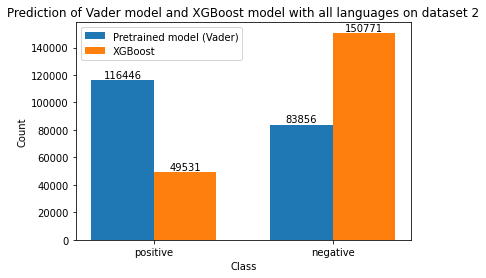

In [144]:
labels = ['positive', 'negative']
values1 = [len([x for x in df_inv_vaderpred['label'] if x == 1]), 
           len([x for x in df_inv_vaderpred['label'] if x == 0])]
values2 = [len([x for x in df_inv_bow_xgbpred['label'] if x == 1]),
           len([x for x in df_inv_bow_xgbpred['label'] if x == 0])]

# Set the width of each bar
width = 0.35

# Create a bar plot for values1
p1 = plt.bar(labels, values1, width, label='Pretrained model (Vader)')

# Create a bar plot for values2
p2 = plt.bar([i + width for i in range(len(values2))], values2, width, label='XGBoost')
plt.bar_label(p1)
plt.bar_label(p2)
# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Prediction of Vader model and XGBoost model with all languages on dataset 2')
plt.xticks(np.arange(2)+0.175,labels)
# Add a legend
plt.legend()

# Show the plot
plt.show()
